# KMeans Clustering

Import Libraries :

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import utm
from sklearn.metrics import silhouette_score
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import geopandas as gpd

Read Dataset :

In [2]:
df_clean_sell = pd.read_csv("Data/cleaned_sell_data.csv")
df_clean_rent = pd.read_csv("Data/cleaned_rent_data.csv")

Important Features

انتخاب ویژگی‌ها

برای خوشه‌بندی داده‌های فروش و اجاره، ویژگی‌های زیر انتخاب شدند:

اجاره (Rent):
rooms_count, utm_easting, utm_northing, city_type, building_age, credit_per_m2

فروش (Sell):
rooms_count, utm_easting, utm_northing, city_type, building_age, price_per_m2

دلیل انتخاب:
ویژگی‌های بالا شامل ترکیبی از ویژگی‌های مکانی (UTM)، ویژگی‌های ساختمانی (سن، تعداد اتاق) و ویژگی اقتصادی (قیمت یا اجاره بر متر مربع) هستند. این ترکیب اجازه می‌دهد خوشه‌ها معنادار و مرتبط با نیاز کاربر باشند.

In [3]:
# ویژگی‌های کلیدی
features_rent = ['rooms_count', 'utm_easting', 'utm_northing', 'city_type', 'building_age','credit_per_m2']
features_sell = ['rooms_count', 'utm_easting', 'utm_northing', 'city_type', 'building_age','price_per_m2']

Normalize sell & rent Features :

استانداردسازی داده‌ها

قبل از خوشه‌بندی، داده‌ها با StandardScaler استاندارد شدند. دلیل این کار:

الگوریتم KMeans نسبت به مقیاس ویژگی‌ها حساس است.

ویژگی‌های UTM و قیمت/اجاره مقیاس‌های متفاوتی دارند.

استانداردسازی باعث می‌شود فاصله‌ها برای خوشه‌بندی به درستی محاسبه شوند.

In [4]:
# داده‌های فروش
X_sell = df_clean_sell[features_sell].copy()
scaler_sell = StandardScaler()
X_sell_scaled = scaler_sell.fit_transform(X_sell)

# داده‌های اجاره
X_rent = df_clean_rent[features_rent].copy()
scaler_rent = StandardScaler()
X_rent_scaled = scaler_rent.fit_transform(X_rent)


Sell & rent KMeans with 10 clusters :

اجرای KMeans

تعداد خوشه‌ها: 10

الگوریتم بر روی داده‌های استاندارد شده اجرا شد.

نتایج خوشه‌ها به ستون جدید cluster اضافه شدند.

In [5]:
# فروش
kmeans_sell = KMeans(n_clusters=10, random_state=42)
clusters_sell = kmeans_sell.fit_predict(X_sell_scaled)
df_clean_sell['cluster'] = clusters_sell

# اجاره
kmeans_rent = KMeans(n_clusters=10, random_state=42)
clusters_rent = kmeans_rent.fit_predict(X_rent_scaled)
df_clean_rent['cluster'] = clusters_rent


Sell & rent Scatter Plot :

ترسیم خوشه‌ها

نمودار Scatter بر اساس UTM برای فروش و اجاره رسم شد:

نقاط هر خوشه با رنگ متفاوت نشان داده شدند (cmap='tab10').

مرکز هر خوشه با علامت X مشکی مشخص شد.

این نمودار به ما کمک می‌کند:

نقاط متعلق به هر خوشه را ببینیم.

توزیع مکانی خوشه‌ها را مشاهده کنیم.

مراکز خوشه‌ها را برای تحلیل موقعیت انتخاب کنیم.

توضیح مراکز خوشه‌ها:
مراکز خوشه‌ها نشان‌دهنده "نمونه متوسط" هر خوشه هستند و می‌توانند برای توصیه ملک به کاربر به عنوان یک نقطه مرجع استفاده شوند.

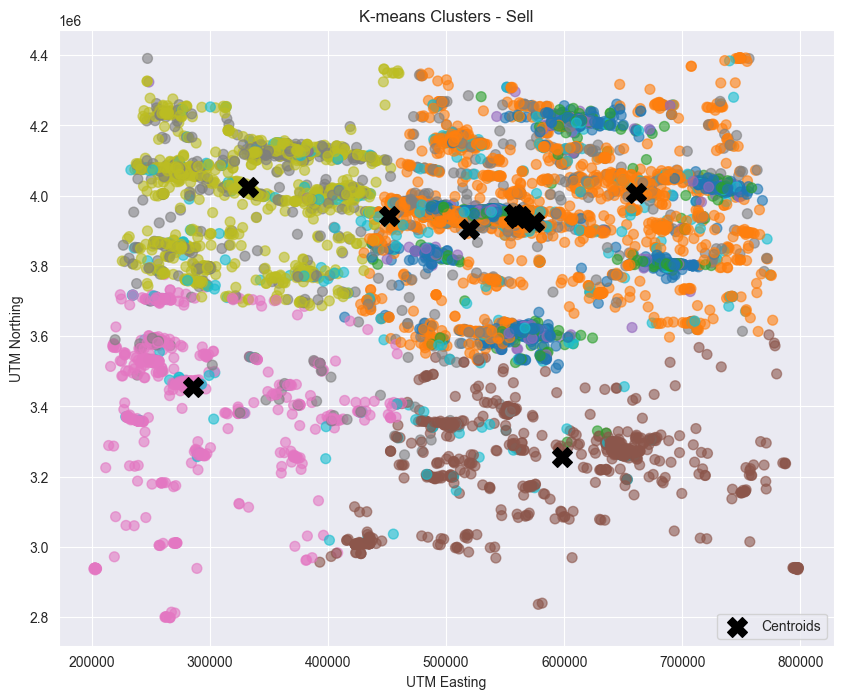

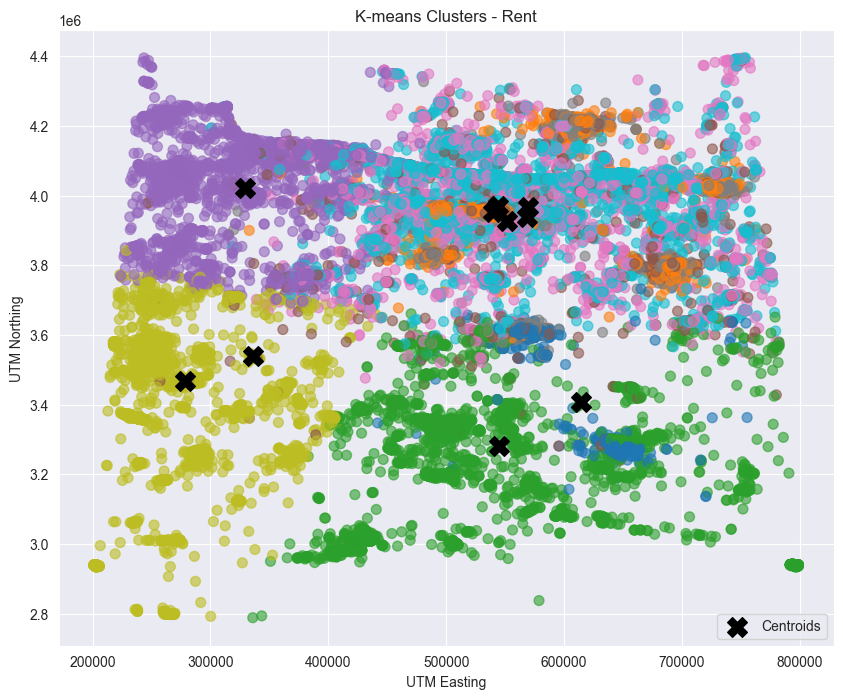

In [6]:
# فروش
plt.figure(figsize=(10,8))
plt.scatter(df_clean_sell['utm_easting'], df_clean_sell['utm_northing'],
            c=df_clean_sell['cluster'], cmap='tab10', s=50, alpha=0.6)
centers = scaler_sell.inverse_transform(kmeans_sell.cluster_centers_)
plt.scatter(centers[:,1], centers[:,2], c='black', s=200, marker='X', label='Centroids')
plt.xlabel('UTM Easting')
plt.ylabel('UTM Northing')
plt.title('K-means Clusters - Sell')
plt.legend()
plt.show()

# اجاره
plt.figure(figsize=(10,8))
plt.scatter(df_clean_rent['utm_easting'], df_clean_rent['utm_northing'],
            c=df_clean_rent['cluster'], cmap='tab10', s=50, alpha=0.6)
centers_rent = scaler_rent.inverse_transform(kmeans_rent.cluster_centers_)
plt.scatter(centers_rent[:,1], centers_rent[:,2], c='black', s=200, marker='X', label='Centroids')
plt.xlabel('UTM Easting')
plt.ylabel('UTM Northing')
plt.title('K-means Clusters - Rent')
plt.legend()
plt.show()


Sell & rent Elbow Method :

انتخاب تعداد خوشه‌ها (Elbow Method)

الگوریتم KMeans برای k از 1 تا 20 اجرا شد و Within-Cluster Sum of Squares (WCSS) محاسبه شد.

نمودار Elbow نشان داد که مقدار مناسب k برای هر مجموعه داده تقریباً 5 است.

دلیل: انتخاب k بر اساس کاهش مناسب WCSS و جلوگیری از overfitting.

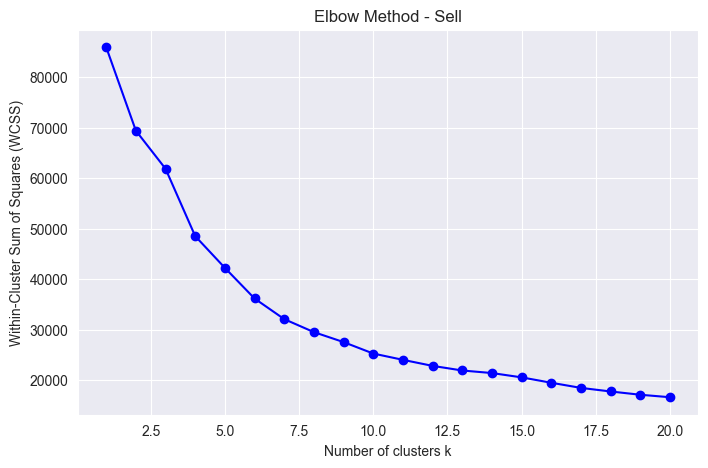

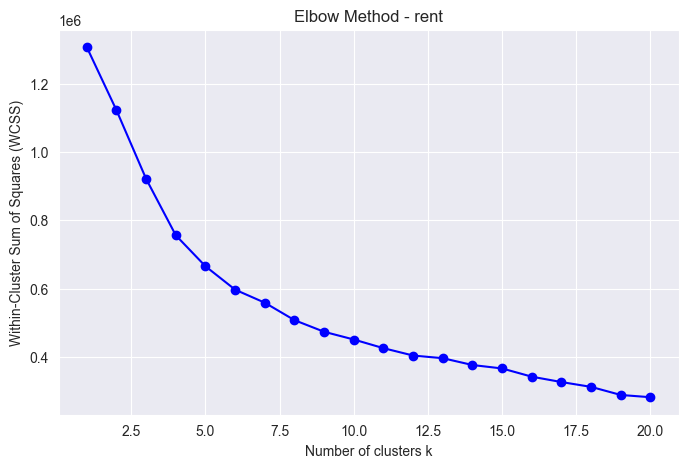

In [7]:
# داده فروش
wcss = []
K_range = range(1, 21)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_sell_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method - Sell')
plt.show()

# داده اجاره
wcss = []
K_range = range(1, 21)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_rent_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method - rent')
plt.show()

sell & rent Silhouette Score

ارزیابی خوشه‌بندی

Silhouette Score برای هر مجموعه داده محاسبه شد

این مقدار نشان می‌دهد که خوشه‌ها نسبتاً تفکیک‌پذیر هستند، هرچند هنوز کمی همپوشانی دارند.

In [10]:
# K-means فروش
score_sell = silhouette_score(X_sell_scaled, df_clean_sell['cluster'])
print(f"Silhouette Score (K-means Sell): {score_sell:.3f}")

# K-means اجاره
score_rent = silhouette_score(X_rent_scaled, df_clean_rent['cluster'])
print(f"Silhouette Score (K-means Rent): {score_rent:.3f}")


Silhouette Score (K-means Sell): 0.265
Silhouette Score (K-means Rent): 0.261


نمایش خوشه‌ها روی نقشه ایران

نقاط فروش و مراکز خوشه‌ها روی نقشه ایران رسم شدند.

برای تبدیل مرکز خوشه‌ها از مختصات UTM به طول و عرض جغرافیایی از interpolation استفاده شد.

هدف: مشاهده توزیع جغرافیایی خوشه‌ها و تشخیص مناطق تمرکز املاک.

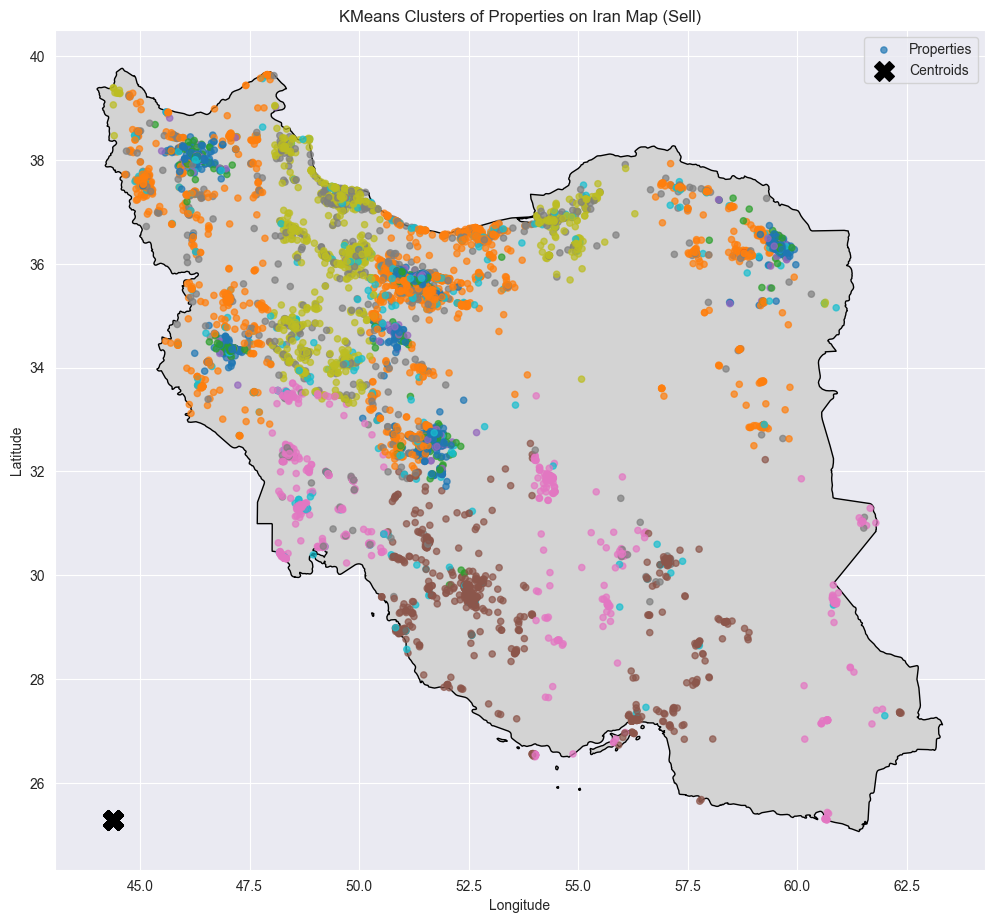

In [9]:
world = gpd.read_file("Geometry Data/ne_10m_admin_0_countries.shp")
iran = world[world['ADMIN'] == 'Iran']

fig, ax = plt.subplots(figsize=(12, 12))
iran.plot(ax=ax, color="lightgray", edgecolor="black")

# رسم نقاط KMeans
plt.scatter(
    df_clean_sell['location_longitude'],
    df_clean_sell['location_latitude'],
    c=df_clean_sell['cluster'],
    cmap='tab10', s=20, alpha=0.7,
    label='Properties'
)

centroids_utm = kmeans_sell.cluster_centers_[:, :2]

centroid_lon = np.interp(centroids_utm[:,0],
                         (df_clean_sell['utm_easting'].min(), df_clean_sell['utm_easting'].max()),
                         (df_clean_sell['location_longitude'].min(), df_clean_sell['location_longitude'].max()))
centroid_lat = np.interp(centroids_utm[:,1],
                         (df_clean_sell['utm_northing'].min(), df_clean_sell['utm_northing'].max()),
                         (df_clean_sell['location_latitude'].min(), df_clean_sell['location_latitude'].max()))

plt.scatter(
    centroid_lon,
    centroid_lat,
    c='black', marker='X', s=200,
    label='Centroids'
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KMeans Clusters of Properties on Iran Map (Sell)")
plt.legend()
plt.show()


kmeans for 5 k

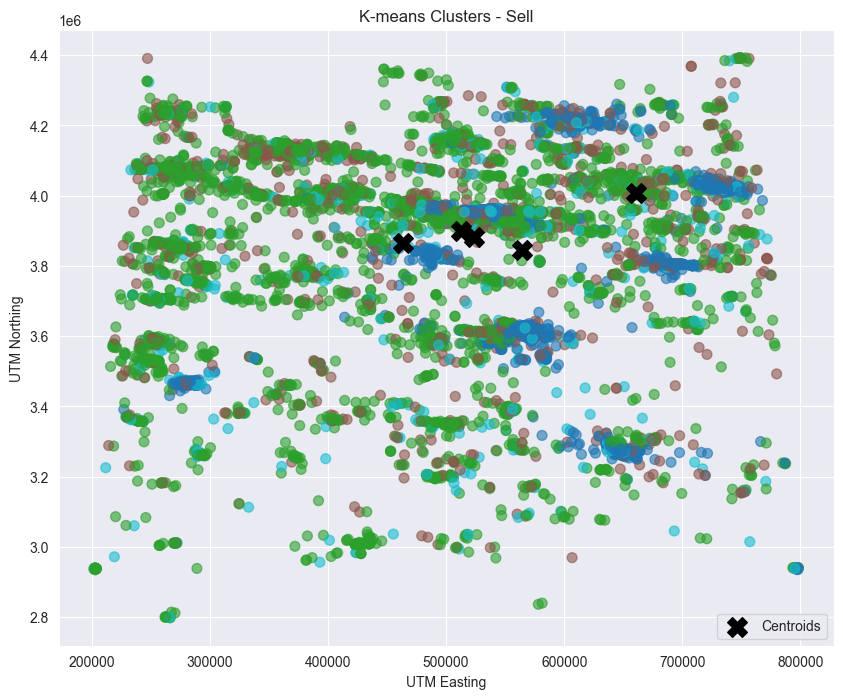

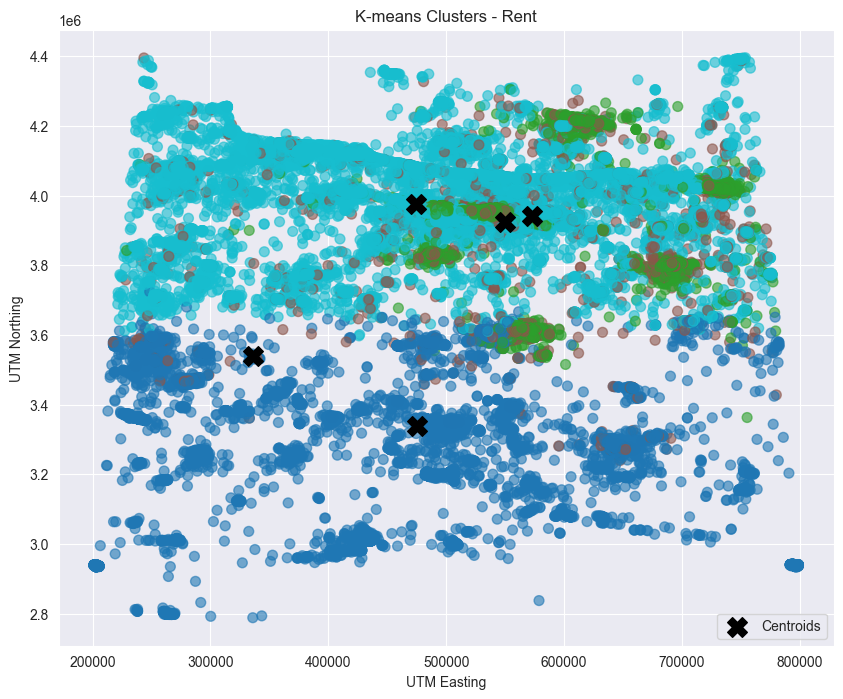

In [11]:
# فروش
kmeans_sell = KMeans(n_clusters=5, random_state=42)
clusters_sell = kmeans_sell.fit_predict(X_sell_scaled)
df_clean_sell['cluster'] = clusters_sell

# اجاره
kmeans_rent = KMeans(n_clusters=5, random_state=42)
clusters_rent = kmeans_rent.fit_predict(X_rent_scaled)
df_clean_rent['cluster'] = clusters_rent

# فروش
plt.figure(figsize=(10, 8))
plt.scatter(df_clean_sell['utm_easting'], df_clean_sell['utm_northing'],
            c=df_clean_sell['cluster'], cmap='tab10', s=50, alpha=0.6)
centers = scaler_sell.inverse_transform(kmeans_sell.cluster_centers_)
plt.scatter(centers[:, 1], centers[:, 2], c='black', s=200, marker='X', label='Centroids')
plt.xlabel('UTM Easting')
plt.ylabel('UTM Northing')
plt.title('K-means Clusters - Sell')
plt.legend()
plt.show()

# اجاره
plt.figure(figsize=(10, 8))
plt.scatter(df_clean_rent['utm_easting'], df_clean_rent['utm_northing'],
            c=df_clean_rent['cluster'], cmap='tab10', s=50, alpha=0.6)
centers_rent = scaler_rent.inverse_transform(kmeans_rent.cluster_centers_)
plt.scatter(centers_rent[:, 1], centers_rent[:, 2], c='black', s=200, marker='X', label='Centroids')
plt.xlabel('UTM Easting')
plt.ylabel('UTM Northing')
plt.title('K-means Clusters - Rent')
plt.legend()
plt.show()


In [12]:
# K-means فروش
score_sell = silhouette_score(X_sell_scaled, df_clean_sell['cluster'])
print(f"Silhouette Score (K-means Sell): {score_sell:.3f}")

# K-means اجاره
score_rent = silhouette_score(X_rent_scaled, df_clean_rent['cluster'])
print(f"Silhouette Score (K-means Rent): {score_rent:.3f}")


Silhouette Score (K-means Sell): 0.262
Silhouette Score (K-means Rent): 0.252


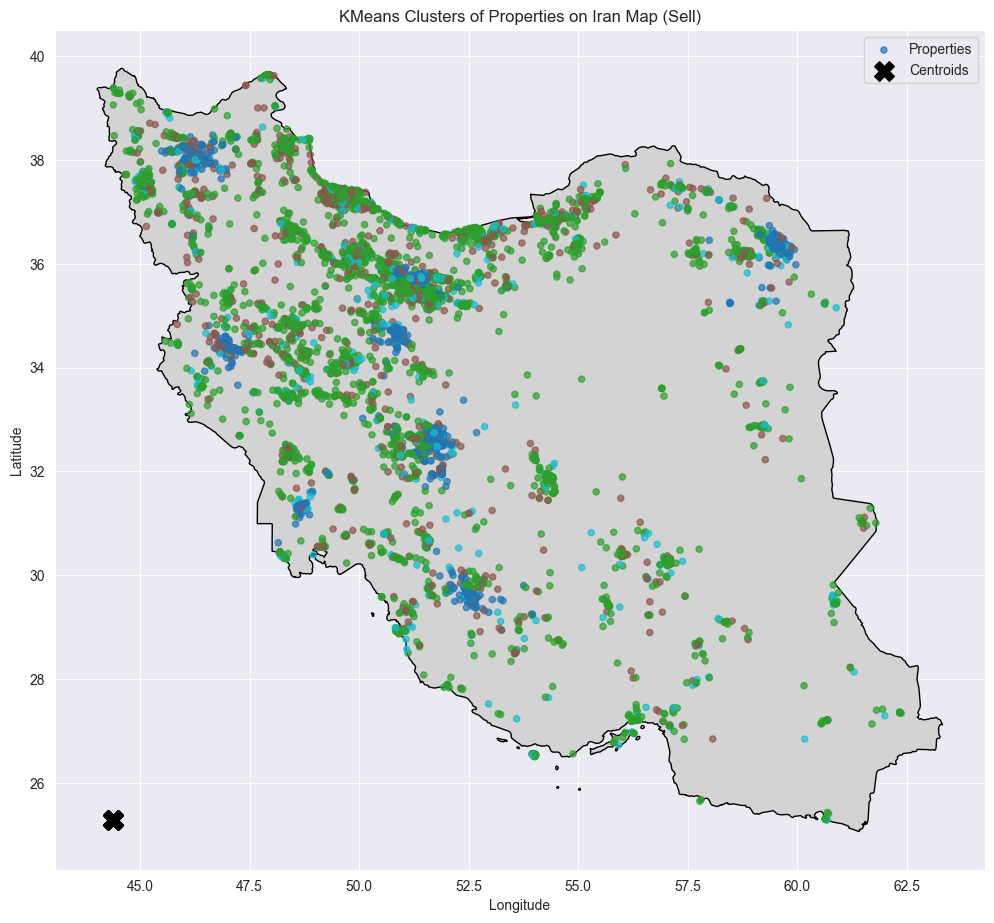

In [13]:
world = gpd.read_file("Geometry Data/ne_10m_admin_0_countries.shp")
iran = world[world['ADMIN'] == 'Iran']

fig, ax = plt.subplots(figsize=(12, 12))
iran.plot(ax=ax, color="lightgray", edgecolor="black")

# رسم نقاط KMeans
plt.scatter(
    df_clean_sell['location_longitude'],
    df_clean_sell['location_latitude'],
    c=df_clean_sell['cluster'],
    cmap='tab10', s=20, alpha=0.7,
    label='Properties'
)

centroids_utm = kmeans_sell.cluster_centers_[:, :2]

centroid_lon = np.interp(centroids_utm[:, 0],
                         (df_clean_sell['utm_easting'].min(), df_clean_sell['utm_easting'].max()),
                         (df_clean_sell['location_longitude'].min(), df_clean_sell['location_longitude'].max()))
centroid_lat = np.interp(centroids_utm[:, 1],
                         (df_clean_sell['utm_northing'].min(), df_clean_sell['utm_northing'].max()),
                         (df_clean_sell['location_latitude'].min(), df_clean_sell['location_latitude'].max()))

plt.scatter(
    centroid_lon,
    centroid_lat,
    c='black', marker='X', s=200,
    label='Centroids'
)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KMeans Clusters of Properties on Iran Map (Sell)")
plt.legend()
plt.show()
